In [1]:
# 한국어 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 데이터 불러오기

In [2]:
import pandas as pd

# 학습 데이터 불러오기
train_data = pd.read_csv('train_OutlierRemoval.csv')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7000 non-null   int64  
 1   ID          7000 non-null   object 
 2   나이          7000 non-null   int64  
 3   키(cm)       7000 non-null   int64  
 4   몸무게(kg)     7000 non-null   int64  
 5   시력          7000 non-null   float64
 6   충치          7000 non-null   int64  
 7   공복 혈당       7000 non-null   int64  
 8   혈압          7000 non-null   float64
 9   중성 지방       7000 non-null   int64  
 10  혈청 크레아티닌    7000 non-null   float64
 11  콜레스테롤       7000 non-null   int64  
 12  고밀도지단백      7000 non-null   float64
 13  저밀도지단백      7000 non-null   float64
 14  헤모글로빈       7000 non-null   float64
 15  요 단백        7000 non-null   int64  
 16  간 효소율       7000 non-null   float64
 17  label       7000 non-null   int64  
dtypes: float64(7), int64(10), object(1)
memory usage: 984.5+ KB


# 모듈 import

In [3]:
!pip install shap xgboost

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

# 데이터 전처리

**컬럼 제거 및 label 분리**

In [5]:
# 'Unnamed: 0' 열 제거
train_data = train_data.drop(columns=['Unnamed: 0'], errors='ignore')

# '콜레스테롤' 피처 제거
train_data = train_data.drop(columns=['콜레스테롤'], errors='ignore')

# ID 열과 목표 변수를 분리
X_train_data = train_data.drop(['ID', 'label'], axis=1)
y_train_data = train_data['label']

# 원래 피처 이름을 저장
feature_names = X_train_data.columns

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=42)

**Standard Scaling**

In [6]:
# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델링

**그리드서치로 하이퍼 파라미터 찾기**

In [7]:
# XGBoost 모델 생성 및 하이퍼파라미터 그리드서치
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


최적의 파라미터

In [8]:
# 최적의 파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


**성능 평가**

Accuracy: 0.7076
Precision: 0.5923
Recall: 0.6265
F1 Score: 0.6089
ROC AUC: 0.7919


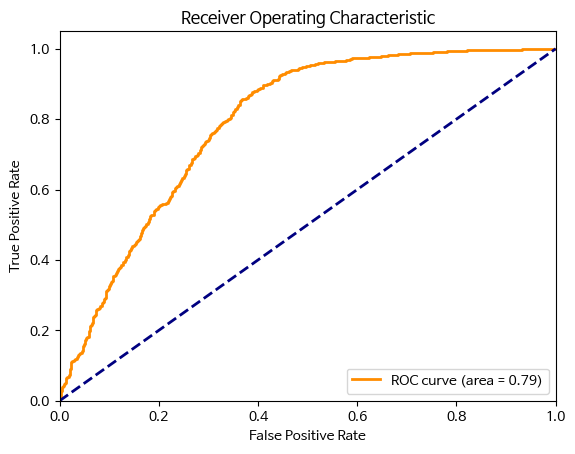

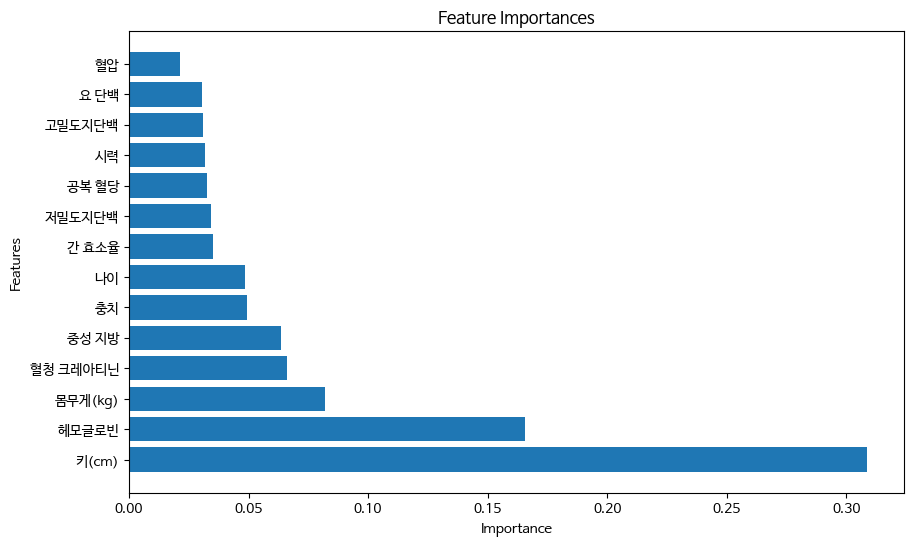

In [9]:
# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 변수 중요도 시각화
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# 교차 검증

In [10]:
# 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f'Cross-Validation accuracy scores: {cv_results}')
print(f'Mean accuracy: {cv_results.mean():.4f}')

Cross-Validation accuracy scores: [0.71734694 0.74795918 0.71428571 0.72653061 0.72244898]
Mean accuracy: 0.7257


# XAI - SHAP

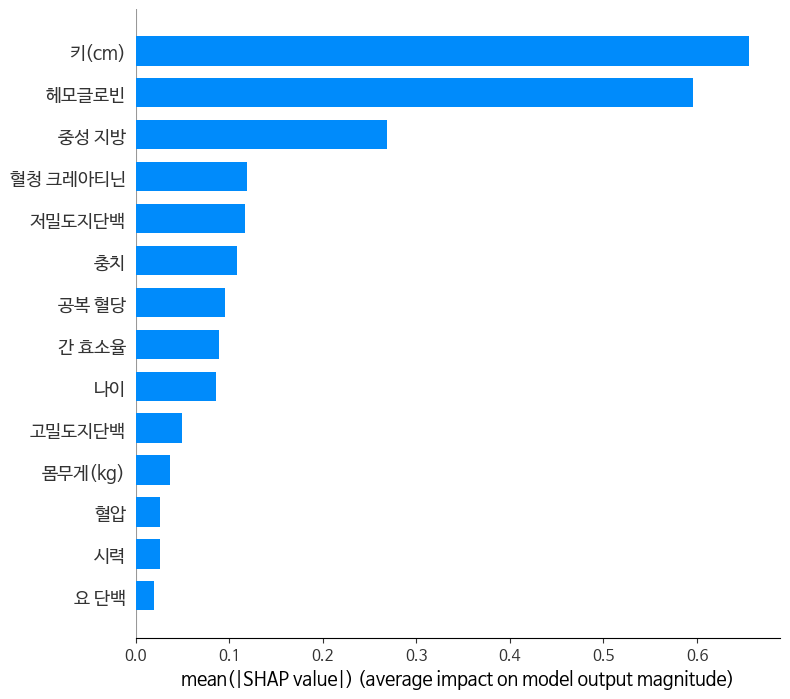

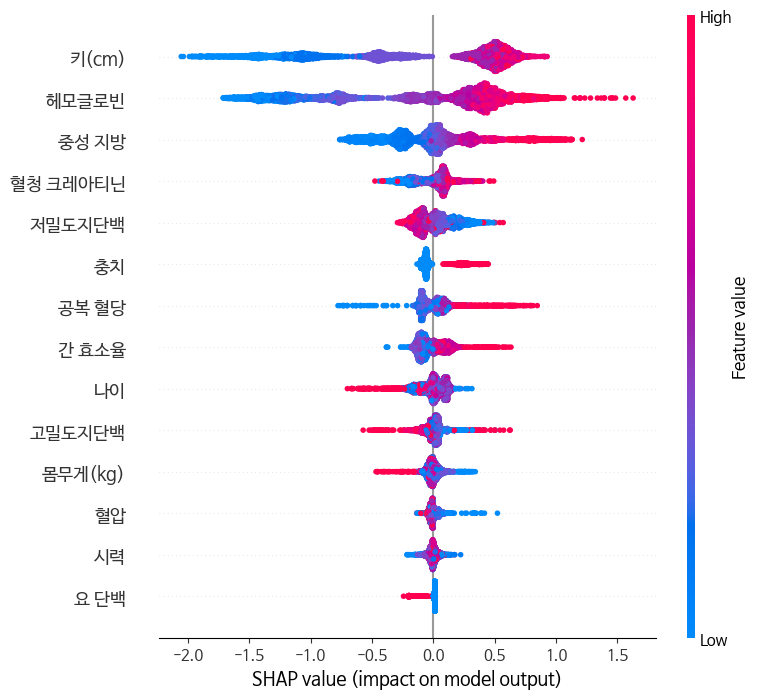

In [11]:
# SHAP 분석 (PCA된 데이터 사용)
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_train_scaled)

# Global feature importance
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names, plot_type="bar")

# Local explanation summary
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names)